<a href="https://colab.research.google.com/github/erdult/Statistics/blob/main/GLM_Assumptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Logistic Regression Assumptions**

When the assumptions of logistic regression analysis are not met, problems such as biased coefficient estimates or very large standard errors for the logistic regression coefficients may lead to invalid statistical inferences.

**Assumption 1** - Appropriate outcome type (Must be categorical)

**Assumption 2** - Linearity of independent variables and log odds

**Assumption 3** - No strongly influential outliers

**Assumption 4** - Absence of multicollinearity

**Assumption 5** - Independence of observations

**Assumption 6** - Sufficiently large sample size

In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
df_raw = pd.read_csv(url)
df_raw.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

# Create categorical variable for traveling alone
df_raw['TravelAlone'] = np.where((df_raw["SibSp"] + df_raw["Parch"])>0, 0, 1).astype('uint8')
df_raw.drop('SibSp', axis=1, inplace=True)
df_raw.drop('Parch', axis=1, inplace=True)
df_raw.drop('PassengerId', axis=1, inplace=True)
df_raw.drop('Name', axis=1, inplace=True)
df_raw.drop('Ticket', axis=1, inplace=True)
df_raw.drop('Cabin', axis=1, inplace=True)
# df_raw.drop('Fare', axis=1, inplace=True)

# Create categorical variables and drop some variables
df_titanic = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"],
                         drop_first=True) # Remove first variable to prevent collinearity

# Fill NaN (median imputation)
df_titanic["Age"].fillna(df_titanic["Age"].median(skipna=True), inplace=True)

# Define dependent and independent variables
X_cols = df_titanic.columns.to_list()[1:]
X = df_titanic[X_cols]
y = df_titanic['Survived']

# Add constant
X = sm.add_constant(X, prepend=False)

df_titanic.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


**Assumption 1 : Appropriate Outcome Type**

- Logistic regression generally works as a classifier, so the type of logistic regression utilized (binary, multinomial, or ordinal) must match the outcome (dependent) variable in the dataset.
- By default, *logistic regression assumes that the outcome variable is binary*, where the number of outcomes is two (e.g., Yes/No).
- If the *dependent variable has three or more outcomes, then multinomial or ordinal logistic regression should be used.*

**How to Check?**
- We can check this assumption by getting the number of different outcomes in the dependent variable. If we want to use binary logistic regression, then there should only be two unique outcomes in the outcome variable.

In [ ]:
# Count unique number of outcomes in dependent variable ('Survived')
print(df_titanic['Survived'].nunique())

2


**Inference:**

- There are only two outcomes (i.e. binary classification of survived or did not survive), so we will be using Binary Logistic Regression (which is the default method we use when we specify family=Binomial in our logit models earlier)

- Other types of Logistic Regression (where outcomes > 2) include:
  1. **Multinomial Logistic Regression:** Target variable has three or more nominal categories such as predicting the type of Wine
  2. **Ordinal Logistic Regression:** Target variable has three or more ordinal categories such as restaurant or product rating from 1 to 5.


**Assumption 2 — Linearity of independent variables and log-odds**

- One of the critical assumptions of logistic regression is that the *relationship between the logit (aka log-odds) of the outcome and each continuous independent variable is linear.*

- The logit is the logarithm of the odds ratio, where p = probability of a positive outcome (e.g., survived Titanic sinking)

  **logit(p) = log(p/1-p)**

**How to Check?**
- **Visual check**
  - We can check logit linearity is by visually inspecting the scatter plot between each predictor and the logit values.

- **Box-Tidwell Test**
  - One of the important assumptions of logistic regression is the *linearity of the logit over the continuous covariates. This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.*
  - The Box-Tidwell transformation (test) can be used to test the linearity in the logit assumption when performing logistic regression.
  - It checks whether the logit transform is a linear function of the predictor, effectively adding the non-linear transform of the original predictor as an interaction term to test if this addition made no better prediction.
  - A statistically significant p-value of the interaction term in the Box-Tidwell transformation means that the linearity assumption is violated
  - If one variable is indeed found to be non-linear, then we can resolve it by incorporating higher order polynomial terms for that variable in the regression analysis to capture the non-linearity (e.g. x^2) .
  - The Box-Tidwell test is used to check for linearity between the predictors and the logit.
  - This is done by adding log-transformed interaction terms between the continuous independent variables and their corresponding natural log into the model.
  - For example, if one of your continuous independent variables is Age, then the interaction term to add as a new variable will be Age * ln(Age).
  - As part of the Box-Tidwell test, we filter our dataset to keep just the continuous independent variables.


In [ ]:
# Box Tidwell only works for positive values. Hence, drop values where x = 0
df_titanic_2 = df_titanic.drop(df_titanic[df_titanic.Age == 0].index)
df_titanic_2 = df_titanic_2.drop(df_titanic[df_titanic.Fare == 0].index)
print(df_titanic_2.head())

   Survived   Age     Fare  TravelAlone  Pclass_2  Pclass_3  Embarked_Q  \
0         0  22.0   7.2500            0         0         1           0   
1         1  38.0  71.2833            0         0         0           0   
2         1  26.0   7.9250            1         0         1           0   
3         1  35.0  53.1000            0         0         0           0   
4         0  35.0   8.0500            1         0         1           0   

   Embarked_S  Sex_male  
0           1         1  
1           0         0  
2           1         0  
3           1         0  
4           1         1  


In [ ]:
# Logistic Regression with statsmodel
# Inclusion of interaction term (logit transform) as part of Box-Tidwell test

df_titanic_lt = df_titanic_2.copy()

# Define continuous variables
continuous_var = ['Age', 'Fare']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
    df_titanic_lt[f'{var}:Log_{var}'] = df_titanic_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_titanic_lt.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Age:Log_Age,Fare:Log_Fare
0,0,22.0,7.2500,0,0,1,0,1,1,68.002934,14.362261
1,1,38.0,71.2833,0,0,0,0,0,0,138.228274,304.141753
2,1,26.0,7.9250,1,0,1,0,1,0,84.710510,16.404927
3,1,35.0,53.1000,0,0,0,0,1,0,124.437182,210.922595
4,0,35.0,8.0500,1,0,1,0,1,1,124.437182,16.789660


In [ ]:
# Keep columns related to continuous variables
cols_to_keep = continuous_var + df_titanic_lt.columns.tolist()[-len(continuous_var):]
cols_to_keep

['Age', 'Fare', 'Age:Log_Age', 'Fare:Log_Fare']

In [ ]:
# Redefine independent variables to include interaction terms
X_lt = df_titanic_lt[cols_to_keep]
y_lt = df_titanic_lt['Survived']

# Add constant
X_lt = sm.add_constant(X_lt, prepend=False)

# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  876
Model:                            GLM   Df Residuals:                      871
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -536.19
Date:                Mon, 09 Oct 2023   Deviance:                       1072.4
Time:                        20:46:05   Pearson chi2:                     881.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1065
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.1123      0.058     -1.948

- We are interested in the p-values for the logit transformed interaction terms of  Age:Log_Age and Fare:Log_Fare
- From the summary table above, we can see that the p value for Fare:Log_Fare is < 0.001, which is statistically significant, whereas Age:Log_Age is not
- This means that there is non-linearity in the Fare feature, and the assumption has been violated
- We can resolve this by including a polynomial term (e.g. Fare^2) to account for the non-linearity

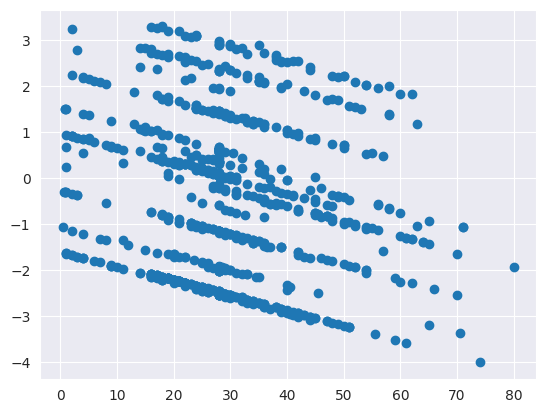

In [ ]:
# Visual Check
# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = df_titanic['Age'].values, y = log_odds);
plt.show()
# Confirming that there is logit linearity for the Age variable
# (Recall earlier that p value for Age:Log Age is 0.101)

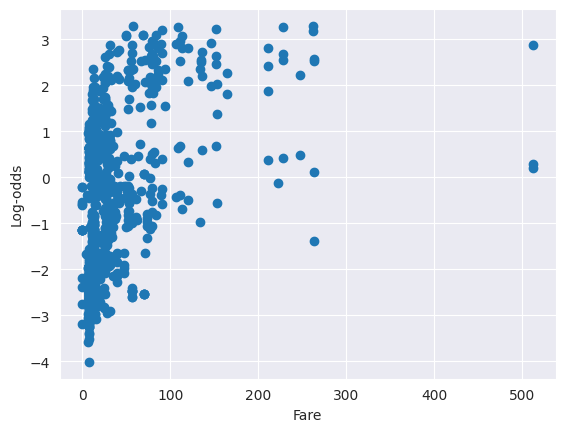

In [ ]:
# Visualize predictor variable vs logit values for Fare
plt.scatter(x = df_titanic['Fare'].values, y = log_odds);
plt.xlabel("Fare")
plt.ylabel("Log-odds")
plt.show()

# Inference :
# Confirming that there is logit NON-linearity for the Fare variable
# (Recall earlier that p value for Fare:Log Fare is <0.001)

**What is a Logit Function and Why Use Logistic Regression?**

- One of the big assumptions of linear models is that the *residuals are normally distributed.*
- This doesn’t mean that Y, the response variable, has to also be normally distributed, but it does have to be continuous, unbounded and measured on an interval or ratio scale.

**Unfortunately, categorical response variables are none of these. (in case of logistic regression output)**

- No matter how many transformations you try, you’re just never going to get normal residuals from a model with a categorical response variable.

- There are a number of alternatives though, and one of the most popular is logistic regression.

In many ways, logistic regression is very similar to linear regression.  One big difference, though, is the logit link function.

**The Logit Link Function**

- A link function is simply a function of the mean of the response variable Y that we use as the response instead of Y itself.

- All that means is when Y is categorical, we use the logit of Y as the response in our regression equation instead of just Y:



- The logit function is the natural log of the odds that Y equals one of the categories.  
- For mathematical simplicity, we’re going to assume Y has only two categories and code them as 0 and 1.
- This is entirely arbitrary – we could have used any numbers.  But these make the math work out nicely, so let’s stick with them.
- P is defined as the probability that Y=1.  So for example, those Xs could be specific risk factors, like age, high blood pressure, and cholesterol level, and P would be the probability that a patient develops heart disease.

**Why Bother With This Logit Function?**

- Well, if we used Y as the outcome variable and tried to fit a line, it wouldn’t be a very good representation of the relationship.  The following graph shows an attempt to fit a line between one X variable and a binary outcome Y.

- You can see a relationship there–higher values of X are associated with more 0s and lower values of X have more 1s.  But it’s not a linear relationship.

Okay, fine.  

*But why mess with logs and odds?  Why not just use P as the outcome variable?  Everyone understands probability.*

Here’s the same graph with probability on the Y axis:

It’s closer to being linear, but it’s still not quite there. *Instead of a linear relationship between X and P, we have a sigmoidal or S-shaped relationship.*

But it turns out that there are a few functions of P that do form reasonably linear relationships with X.  These include:
1. Square root of arcsin
2. Complimentary log-log
3. Probit
4. Logit

**Assumption 3 : No strongly influential outliers**

- Logistic regression assumes that there are no highly influential outlier data points, as they distort the outcome and accuracy of the model.
- Note that not all outliers are influential observations. Rather, outliers have the potential to be influential.

*To assess this assumption, we need to check whether both criteria are satisfied, i.e., influential and outlier.*

**How to Check?**

(i) Influence
- We can use Cook’s Distance to determine the influence of a data point, and it is calculated based on its residual and leverage. It summarizes the changes in the regression model when that particular (ith) observation is removed.
- There are different opinions regarding what cut-off values to use. One standard threshold is 4/N (where N = number of observations), meaning that observations with Cook’s Distance > 4/N are deemed as influential.

(ii) Outliers
- We use standardized residuals to determine whether a data point is an outlier or not.
- Data points with absolute standardized residual values greater than 3 represent possible extreme outliers.

(iii) Putting Both Together
- We can identify the strongly influential outlier data points by finding the top observations based on thresholds defined earlier for Cook’s Distance and standardized residuals.
- When outliers are detected, they should be treated accordingly, such as removing or transforming them.

In [ ]:
# Use GLM method for logreg here so that we can retrieve the influence measures
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -398.95
Date:                Mon, 09 Oct 2023   Deviance:                       797.91
Time:                        20:46:06   Pearson chi2:                     933.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3536
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0333      0.008     -4.397      

In [ ]:
from scipy import stats

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()

,cooks_d,std_resid
0,0.000041,0.330871
1,0.000046,0.243040
2,0.001006,0.866265
3,0.000091,0.313547
4,0.000017,0.280754


Threshold for Cook Distance = 0.004489337822671156


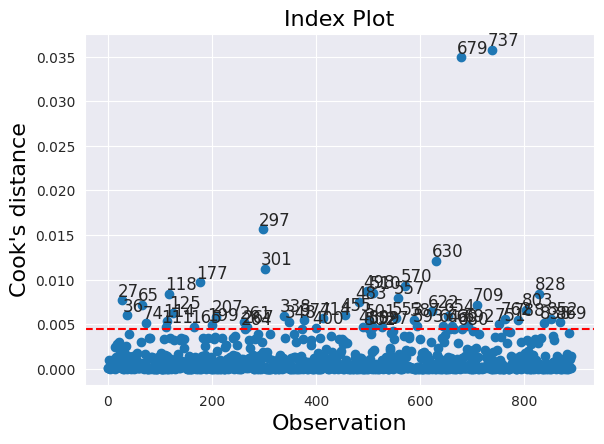

In [ ]:
# Set Cook's distance threshold
cook_threshold = 4 / len(df_titanic)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [ ]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(df_titanic)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 6.1%


In [ ]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(df_titanic)),1)

In [ ]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
297,0.015636,4.951289
570,0.009277,3.030644
498,0.008687,3.384369
338,0.005917,4.461842
414,0.005666,4.387731


In [ ]:
# Deep dive into index 297 (extreme outlier)
df_titanic.iloc[297]

Survived         0.00
Age              2.00
Fare           151.55
TravelAlone      0.00
Pclass_2         0.00
Pclass_3         0.00
Embarked_Q       0.00
Embarked_S       1.00
Sex_male         0.00
Name: 297, dtype: float64

- It is important to note that for data points with relative high Cook's distances, it does not automatically mean that it should be immediately removed from the dataset.
- It is essentially an indicator to highlight which data points are worth looking deeper into, to understand whether they are true anomalies or not
- In practice, an assessment of “large” values is a judgement call based on experience and the particular set of data being analyzed.
- In addition, based on our pre-defined threshold (4/N), only 5% (51/891) of the points are in the outlier zone, which is small as well. The issue comes when there is a significant number of data points classified as outliers.

**Assumption 4 : Absence of Multicollinearity**
- Multicollinearity corresponds to a situation where the data contain highly correlated independent variables.
- This is a problem because it reduces the precision of the estimated coefficients, which weakens the statistical power of the logistic regression model.

**How to Check?**
1. **Coorelation Matrix**
  - Correlation matrix can be difficult to interpret when there are many independent variables
  - Furthermore, not all collinearity problems can be detected by inspection of the correlation matrix: it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation.
  - As such, we use Variance Inflation Factor (VIF) instead

2. **Variation Inflation Factor(VIF)**
  - Variance Inflation Factor (VIF) measures the degree of multicollinearity in a set of independent variables.
  - Mathematically, it is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable.
  - The smallest possible value for VIF is 1 (i.e., a complete absence of collinearity). As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of multicollinearity.

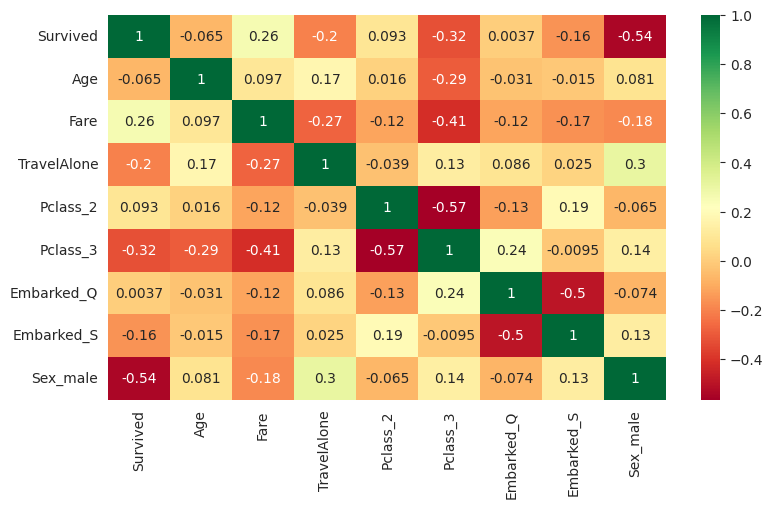

In [ ]:
corrMatrix = df_titanic.corr()
plt.subplots(figsize=(9, 5))
sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
plt.show()

In [ ]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(df_titanic)

,variables,VIF
0,Survived,1.944148
1,Age,5.005814
2,Fare,1.793238
3,TravelAlone,3.030957
4,Pclass_2,1.968630
5,Pclass_3,3.524367
6,Embarked_Q,1.591633
7,Embarked_S,4.795192
8,Sex_male,3.708845


In [ ]:
# Inference :
# The threshold for VIF is usually 5 (i.e. values above 5 means there is presence of multicollinearity)
# Since all the variables have VIF <5, it means that there is no multicollinearity, and this assumption is satisfied
# Let's have a look at the situation where we did not drop the first variable upon getting dummies:

# Avoid dropping first variables upon get_dummies
df_test = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"],
                           drop_first=False)
df_test.drop('Sex_female', axis=1, inplace=True)
df_test["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)
calc_vif(df_test)

# Inference :
# From the results,
# we can see that there are numerous VIF values way above the threshold of 5
# when we do not drop at least 1 category from the dummy categories we generated
# This is a clear sign of multicollinearity

,variables,VIF
0,Survived,1.636129
1,Age,1.247705
2,Fare,1.690089
3,TravelAlone,1.223353
4,Pclass_1,117.152079
5,Pclass_2,99.102382
6,Pclass_3,260.025558
7,Embarked_C,69.936806
8,Embarked_Q,36.792002
9,Embarked_S,91.326578


**Assumption 5 : Independence of observations**
- The observations must be independent of each other, i.e., they should not come from repeated or paired data.
- This means that each observation is not influenced by or related to the rest of the observations.

**How to Check?**
- This independence assumption is automatically met for our Titanic example dataset since the data consists of individual passenger records.
- This assumption would be more of a concern when dealing with time-series data, where the correlation between sequential observations (auto-correlation) can be an issue.
- Nonetheless, there are still ways to check for the independence of observations for non-time series data. In such cases, the ‘time variable’ is the order of observations (i.e., index numbers).
- In particular, we can create the Residual Series plot where we plot the deviance residuals of the logit model against the index numbers of the observations.

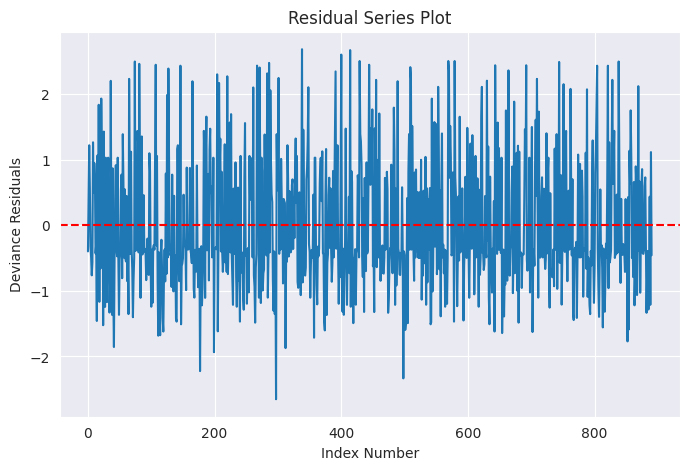

In [ ]:
# Setup logistic regression model using GLM method so that we can retrieve residuals
logit_results = GLM(y, X, family=families.Binomial()).fit()

# Setup plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number",
                     ylabel="Deviance Residuals")

# Generate residual series plot using standardized deviance residuals
ax.plot(df_titanic.index.tolist(),
        stats.zscore(logit_results.resid_deviance))

# Draw horizontal line at y=0
plt.axhline(y = 0, ls="--", color='red')

# Inference:
# Since the residuals in the plot above appear to be randomly scattered around the centerline
# of zero, we can infer (visually) that the assumption is satisfied.
# From the above Deviance residuals versus index number plot,
# we can see that the assumption of independence of errors is satisfied

**Assumption 6 : Sufficiently large sample size**

- There should be an adequate number of observations for each independent variable in the dataset to avoid creating an overfit model.

**How to Check?**
- Like Cook’s distance, there are numerous opinions on the rule of thumb to determine a ‘sufficiently large’ quantity.
- One rule of thumb is that there should be at least 10 observations with the least frequent outcome for each independent variable.
- We can check this by retrieving the value counts for each variable.
- Another way to determine a large sample size is that the total number of observations should be greater than 500. We can check this by getting the length of the entire data frame.


In [ ]:
# Find total number of observations
print("Rows in the Dataframe :",len(df_titanic))

print("Categorize wise Distribution")
# Get value counts for independent variables (mainly focus on categorical)
for col in df_titanic.columns.to_list()[1:]:
    if df_titanic.dtypes[col] == 'uint8': # Keep categorical variables only
        print(df_titanic[col].value_counts())

Rows in the Dataframe : 891
Categorize wise Distribution
1    537
0    354
Name: TravelAlone, dtype: int64
0    707
1    184
Name: Pclass_2, dtype: int64
1    491
0    400
Name: Pclass_3, dtype: int64
0    814
1     77
Name: Embarked_Q, dtype: int64
1    644
0    247
Name: Embarked_S, dtype: int64
1    577
0    314
Name: Sex_male, dtype: int64


**Comparison with Linear Regression**

- Although the assumptions for logistic regression differ from linear regression, several assumptions still hold for both techniques.

**Differences**
- Logistic regression does not require a linear relationship between the dependent and independent variables. However, it still needs independent variables to be linearly related to the log-odds of the outcome.
- Homoscedasticity (constant variance) is required in linear regression but not for logistic regression.
- The error terms (residuals) must be normally distributed for linear regression but not required in logistic regression.

**Similarities**
- Absence of multicollinearity
- Observations are independent of each other

**Summary**

Here’s a recap of the assumptions we have covered:
1. Appropriate outcome type
2. Linearity of independent variables and log-odds
3. No strongly influential outliers
4. Absence of multicollinearity
5. Independence of observations
6. Sufficiently large sample size